# 🧠 Medical Imaging Final Project  
### MIC — Spring 2025  
### **Team 1**

**Team Members:**  
- Lam Nguyen  
- Faramarz Aboutalebi  

---

This project focuses on applying deep learning techniques for tumor classification in MRI brain scans using convolutional neural networks and interpretability tools. The notebook includes data preprocessing, model training with transfer learning, performance evaluation, visualization techniques (Grad-CAM, ROC, PR curves), and several diagnostic tools.


# Step 1: Environment Setup and Library Imports

In [1]:
# Install necessary libraries from a predefined requirements list
%pip install -r requirements2.txt

Note: you may need to restart the kernel to use updated packages.


In [1]:
# Bring in essential modules and verify GPU access
import os
import numpy as np
import random
import tensorflow as tf
from PIL import Image, ImageEnhance
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
import mplcyberpunk
plt.style.use("cyberpunk")

# Check if GPU is available and show basic info
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print("🔋 GPU detected — accelerated training enabled.")
    for device in gpu_devices:
        print("Device in use:", device)
else:
    print("⚙️ Training will proceed on CPU — no GPU found.")



2025-04-15 23:41:51.921859: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-15 23:41:51.927959: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744774911.935819   21691 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744774911.938359   21691 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-15 23:41:51.946331: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

🔋 GPU detected — accelerated training enabled.
Device in use: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Device in use: PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


# Step 2: Dataset Path Setup and Class Mapping

In [2]:
# Configure dataset paths relative to project location
project_root = os.getcwd()
train_path = os.path.join(project_root, "dataset", "Training")
test_path = os.path.join(project_root, "dataset", "Testing")

print("Train Data Path:", train_path)
print("Test Data Path:", test_path)

# Fetch image paths and labels from folder hierarchy
def collect_dataset_info(data_dir):
    image_paths, image_labels = [], []
    for category in os.listdir(data_dir):
        category_dir = os.path.join(data_dir, category)
        for img_name in os.listdir(category_dir):
            image_paths.append(os.path.join(category_dir, img_name))
            image_labels.append(category)
    return shuffle(image_paths, image_labels)

train_images, train_classes = collect_dataset_info(train_path)
test_images, test_classes = collect_dataset_info(test_path)



Train Data Path: /mnt/Creative/SoftwareDevelopment/CAP_5516_Medical_Imaging_Computing/Final_Project/Brain-Tumor-Detection-Using-Deep-Learning-MRI-Images-Detection-Using-Computer-Vision/dataset/Training
Test Data Path: /mnt/Creative/SoftwareDevelopment/CAP_5516_Medical_Imaging_Computing/Final_Project/Brain-Tumor-Detection-Using-Deep-Learning-MRI-Images-Detection-Using-Computer-Vision/dataset/Testing


# Step 3: Random Image Sample Preview

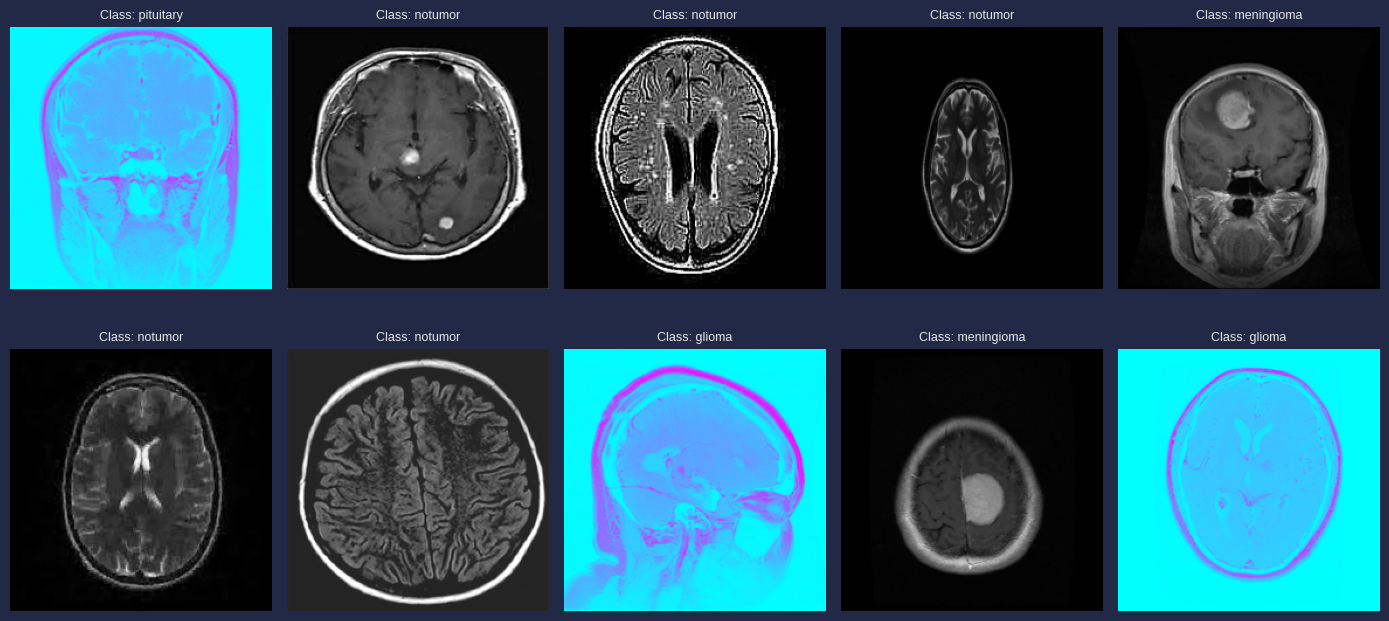

In [3]:
# Preview a few training images with labels
def preview_samples(images, labels, count=10):
    selected = random.sample(range(len(images)), count)
    fig, axarr = plt.subplots(2, 5, figsize=(14, 7))
    axarr = axarr.flatten()

    for i, idx in enumerate(selected):
        img = Image.open(images[idx]).resize((224, 224))
        axarr[i].imshow(img)
        axarr[i].axis('off')
        axarr[i].set_title(f"Class: {labels[idx]}", fontsize=9)

    plt.tight_layout()
    plt.show()

# Display random examples from training set
preview_samples(train_images, train_classes)


# Step 4: Preprocessing Functions (Augmentation, Normalization)

In [4]:
# Define input size
IMG_SIZE = 128

# Enhance contrast and brightness
def enhance(img_array):
    image = Image.fromarray(np.uint8(img_array))
    brightness = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    contrast = ImageEnhance.Contrast(brightness).enhance(random.uniform(0.8, 1.2))
    return np.array(contrast) / 255.0

# Process paths into augmented arrays
def process_images(image_list):
    output = []
    for filepath in image_list:
        raw = load_img(filepath, target_size=(IMG_SIZE, IMG_SIZE))
        enhanced = enhance(raw)
        output.append(enhanced)
    return np.array(output)

# Convert text labels into numeric indices
def label_encoder(label_list):
    unique = os.listdir(train_path)
    return np.array([unique.index(lbl) for lbl in label_list])


# Step 5: Custom Data Generator for Mini-Batch Training

In [5]:
# Mini data loader for training
def image_batch_gen(imgs, lbls, size=12, reps=1):
    for _ in range(reps):
        for i in range(0, len(imgs), size):
            x_batch = process_images(imgs[i:i+size])
            y_batch = label_encoder(lbls[i:i+size])
            yield x_batch, y_batch


# Step 6: Model Definition & Compilation

In [6]:
# Load base CNN and freeze most layers
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in vgg_base.layers:
    layer.trainable = False
for layer in vgg_base.layers[-3:]:
    layer.trainable = True

# Add custom classifier
model = Sequential([
    Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    vgg_base,
    Flatten(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(len(os.listdir(train_path)), activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])


I0000 00:00:1744774927.484031   21691 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21923 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1744774927.485602   21691 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22321 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:02:00.0, compute capability: 8.6


# Step 7: Training the Model and Visualizing Learning Curve

### 🧠 Model Training Description

In this step, we train our convolutional neural network (CNN), which is based on a pre-trained VGG16 backbone. The training process uses a custom mini-batch data generator that applies random brightness and contrast augmentations to the input images. We use a batch size of 20 and train the model for 5 epochs.

The training loop is powered by the `model.fit()` method, which accepts our generator function as input. We compute the `steps_per_epoch` by dividing the number of training images by the batch size, ensuring full dataset coverage in each epoch. The optimizer used is Adam with a learning rate of 1e-4, and the loss function is sparse categorical crossentropy, which is suitable for multi-class classification with integer labels.

Training metrics such as loss and accuracy are recorded in the `history` object, which is later used to visualize the model’s learning progress.

Epoch 1/15


I0000 00:00:1744774932.248812   21862 service.cc:148] XLA service 0x78b9ac005720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744774932.248842   21862 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
I0000 00:00:1744774932.248847   21862 service.cc:156]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-04-15 23:42:12.269124: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744774932.385442   21862 cuda_dnn.cc:529] Loaded cuDNN version 90800
E0000 00:00:1744774932.597702   21862 buffer_comparator.cc:157] Difference at 32: 0.00620233, expected 0.13161
E0000 00:00:1744774932.597726   21862 buffer_comparator.cc:157] Difference at 90: 0.0206105, expected 0.136851
E0000 00:00:1744774932.597728   21862 buffer_comparator.cc:157] Difference at 11

  5/178 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 1.4079 - sparse_categorical_accuracy: 0.3162

I0000 00:00:1744774934.497518   21862 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


178/178 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 0.6913 - sparse_categorical_accuracy: 0.7111
Epoch 2/15


E0000 00:00:1744774939.614696   21858 buffer_comparator.cc:157] Difference at 32: 0.0423904, expected 0.634217
E0000 00:00:1744774939.614729   21858 buffer_comparator.cc:157] Difference at 33: 0.0294661, expected 0.286613
E0000 00:00:1744774939.614731   21858 buffer_comparator.cc:157] Difference at 34: 0.0250457, expected 0.671414
E0000 00:00:1744774939.614732   21858 buffer_comparator.cc:157] Difference at 35: 0.00680266, expected 0.775687
E0000 00:00:1744774939.614733   21858 buffer_comparator.cc:157] Difference at 36: 0.0144271, expected 0.928498
E0000 00:00:1744774939.614734   21858 buffer_comparator.cc:157] Difference at 37: 0.0114249, expected 0.746042
E0000 00:00:1744774939.614735   21858 buffer_comparator.cc:157] Difference at 38: 0.0461712, expected 0.915075
E0000 00:00:1744774939.614736   21858 buffer_comparator.cc:157] Difference at 39: 0.0187145, expected 0.29402
E0000 00:00:1744774939.614737   21858 buffer_comparator.cc:157] Difference at 40: 0.048444, expected 0.796223
E0

178/178 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.2932 - sparse_categorical_accuracy: 0.8876
Epoch 3/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.2016 - sparse_categorical_accuracy: 0.9225
Epoch 4/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.1391 - sparse_categorical_accuracy: 0.9469
Epoch 5/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.1113 - sparse_categorical_accuracy: 0.9562
Epoch 6/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0853 - sparse_categorical_accuracy: 0.9674
Epoch 7/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0674 - sparse_categorical_accuracy: 0.9768
Epoch 8/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0436 - sparse_categorical_accuracy: 0.9860
Epoch 9/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0385 - sparse_categorical_accuracy: 0.9894
Epoch 10/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0375 - sparse_categorical_accuracy: 0.9894
Epoch 11/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - 

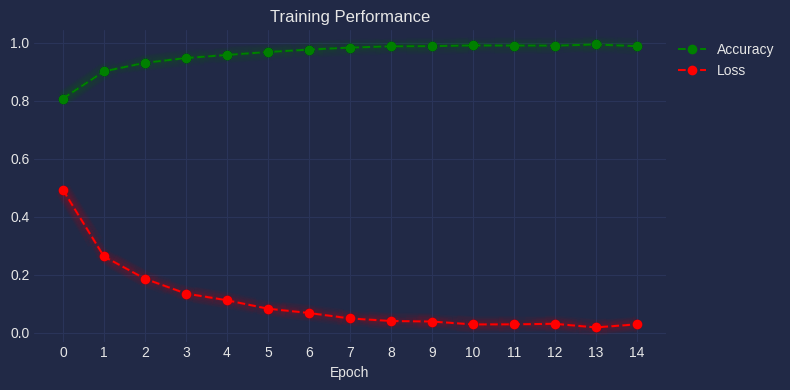

In [7]:
# Define training settings
BATCH = 32
EPOCHS = 15
STEPS = len(train_images) // BATCH

# Train
history = model.fit(
    image_batch_gen(train_images, train_classes, size=BATCH, reps=EPOCHS),
    steps_per_epoch=STEPS,
    epochs=EPOCHS
)

# Plot accuracy and loss
plt.figure(figsize=(8, 4))
plt.plot(history.history['sparse_categorical_accuracy'], 'go--', label='Accuracy')
plt.plot(history.history['loss'], 'ro--', label='Loss')
plt.grid(True)
plt.xlabel('Epoch')
plt.title("Training Performance")
plt.xticks(range(EPOCHS))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
mplcyberpunk.make_lines_glow()
plt.show()


In [9]:
!nvidia-smi

Tue Apr 15 23:43:51 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.06             Driver Version: 570.124.06     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        Off |   00000000:01:00.0  On |                  N/A |
| 75%   39C    P2            120W /  350W |   22582MiB /  24576MiB |      5%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Step 8: Model Evaluation, ROC Curve, and Saving

 1/41 ━━━━━━━━━━━━━━━━━━━━ 16s 414ms/step

E0000 00:00:1744775015.386657   21856 buffer_comparator.cc:157] Difference at 64: 0.0114956, expected 65.568
E0000 00:00:1744775015.386681   21856 buffer_comparator.cc:157] Difference at 65: 0.0214919, expected 66.5784
E0000 00:00:1744775015.386683   21856 buffer_comparator.cc:157] Difference at 66: 0.0461885, expected 66.6715
E0000 00:00:1744775015.386684   21856 buffer_comparator.cc:157] Difference at 67: 0.0511238, expected 70.089
E0000 00:00:1744775015.386685   21856 buffer_comparator.cc:157] Difference at 68: 0.0530081, expected 67.9147
E0000 00:00:1744775015.386687   21856 buffer_comparator.cc:157] Difference at 69: 0.0151476, expected 69.0356
E0000 00:00:1744775015.386688   21856 buffer_comparator.cc:157] Difference at 70: 0.00579177, expected 70.3378
E0000 00:00:1744775015.386689   21856 buffer_comparator.cc:157] Difference at 71: 0.0367224, expected 75.2111
E0000 00:00:1744775015.386690   21856 buffer_comparator.cc:157] Difference at 72: 0.0243734, expected 64.8266
E0000 00:00

37/41 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

E0000 00:00:1744775016.292945   21859 buffer_comparator.cc:157] Difference at 64: 1.45052, expected 67.4759
E0000 00:00:1744775016.292970   21859 buffer_comparator.cc:157] Difference at 65: 0.127215, expected 67.4586
E0000 00:00:1744775016.292978   21859 buffer_comparator.cc:157] Difference at 66: 1.35202, expected 63.7247
E0000 00:00:1744775016.292979   21859 buffer_comparator.cc:157] Difference at 67: 0.410685, expected 65.4951
E0000 00:00:1744775016.292981   21859 buffer_comparator.cc:157] Difference at 68: 1.56476, expected 72.655
E0000 00:00:1744775016.292983   21859 buffer_comparator.cc:157] Difference at 69: 0.647422, expected 71.6956
E0000 00:00:1744775016.292985   21859 buffer_comparator.cc:157] Difference at 70: 1.18007, expected 70.0244
E0000 00:00:1744775016.292986   21859 buffer_comparator.cc:157] Difference at 71: 0.881744, expected 71.6975
E0000 00:00:1744775016.292987   21859 buffer_comparator.cc:157] Difference at 72: 1.51325, expected 69.4053
E0000 00:00:1744775016.29

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
Evaluation Summary:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       300
           1       0.93      0.95      0.94       306
           2       0.99      1.00      1.00       405
           3       0.99      0.97      0.98       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



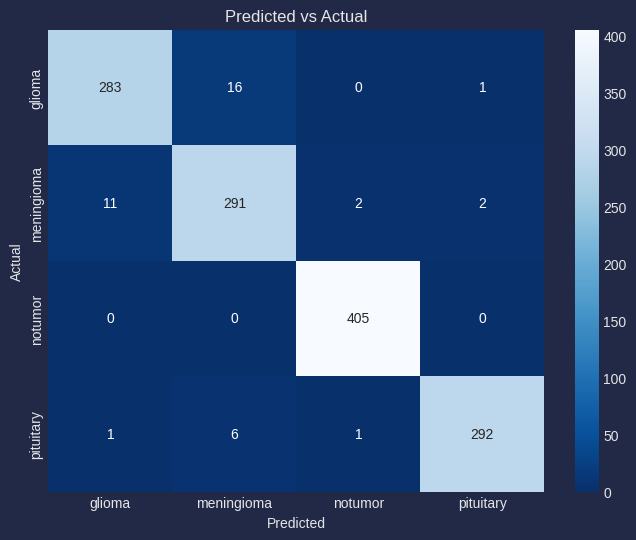

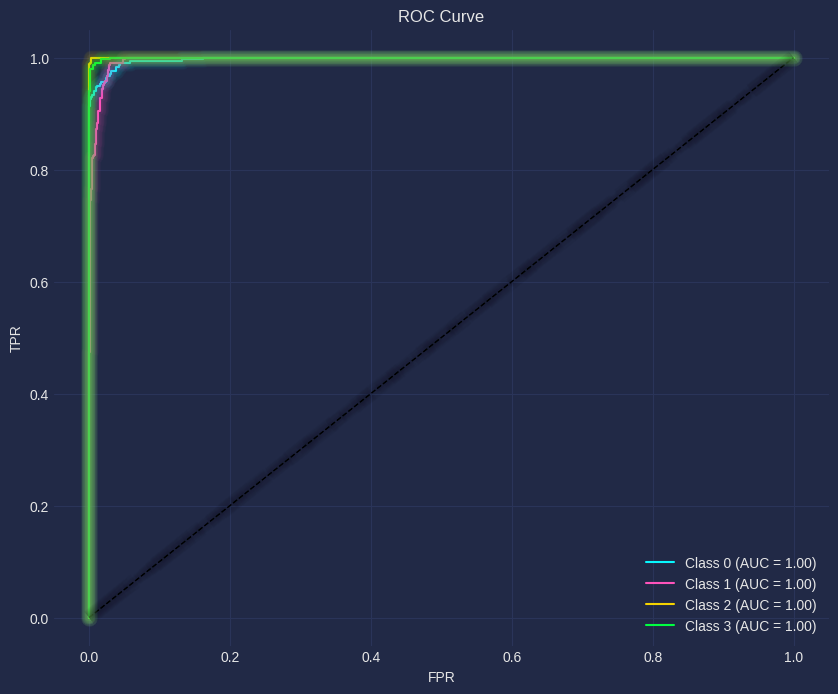

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

# Prepare test data
x_test = process_images(test_images)
y_test = label_encoder(test_classes)
y_prob = model.predict(x_test)
y_pred = np.argmax(y_prob, axis=1)

# Classification report
print("Evaluation Summary:")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues_r',
            xticklabels=os.listdir(train_path),
            yticklabels=os.listdir(train_path))
plt.title("Predicted vs Actual")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC & AUC computation for each class
y_test_bin = label_binarize(y_test, classes=np.arange(len(os.listdir(train_path))))
roc_data = {}

plt.figure(figsize=(10, 8))
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    score = auc(fpr, tpr)
    roc_data[i] = score
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {score:.2f})")

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.title("ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc='lower right')
plt.grid(True)
mplcyberpunk.make_lines_glow()
plt.show()

# Save model
model.save("checkpoints/vgg16_checkpoint.keras")


# Step 9: Inference & Display

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


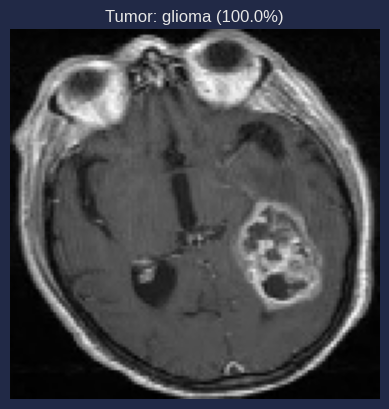

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


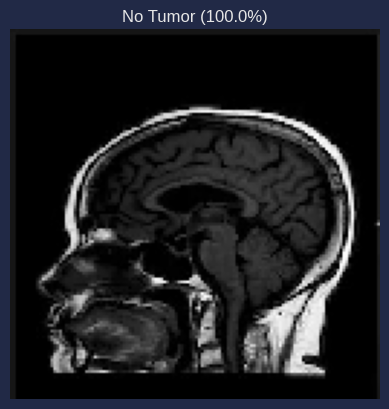

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


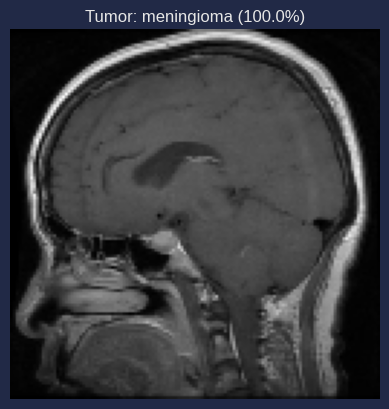

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


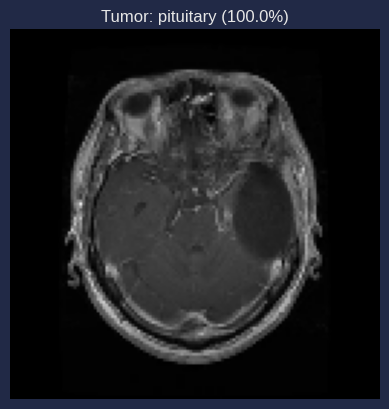

In [10]:
from tensorflow.keras.models import load_model
from keras.preprocessing.image import img_to_array

# Reload saved model
model = load_model("checkpoints/vgg16_checkpoint.keras")

# Predefined class mapping (hardcoded)
tumor_types = ['pituitary', 'glioma', 'notumor', 'meningioma']

# Tumor prediction and visualizer
def tumor_predictor(filepath, model, img_dim=128):
    try:
        image = load_img(filepath, target_size=(img_dim, img_dim))
        array = img_to_array(image) / 255.0
        array = np.expand_dims(array, axis=0)

        result = model.predict(array)
        index = np.argmax(result, axis=1)[0]
        confidence = np.max(result, axis=1)[0]

        label = tumor_types[index]
        verdict = "No Tumor" if label == 'notumor' else f"Tumor: {label}"

        plt.imshow(image)
        plt.axis("off")
        plt.title(f"{verdict} ({confidence * 100:.1f}%)")
        plt.show()
    except Exception as error:
        print("Error:", error)

# Example images (combined former cells)
test_cases = [
    'Te-meTr_0001.jpg',
    'Te-noTr_0004.jpg',
    'Te-piTr_0003.jpg',
    'Te-gl_0015.jpg'
]

for path in test_cases:
    tumor_predictor(path, model)


# Step 10: Grad-CAM Visualization for Model Interpretability

In [10]:
# Retrieve the input shape of the first layer
input_shape = model.layers[0].input_shape
print("Input shape:", input_shape)

Input shape: (None, 128, 128, 3)


In [11]:
# Define Input and outputs

inputs = tf.keras.Input(shape=(128,128,3))
outputs = model(inputs)

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,301,582 (104.15 MB)

 Trainable params: 5,768,836 (22.01 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

 Optimizer params: 11,537,674 (44.01 MB)

In [16]:
for i, layer in enumerate(model.layers):
    print(f"Layer {i}: {layer.name}")

Layer 0: vgg16
Layer 1: flatten
Layer 2: dropout
Layer 3: dense
Layer 4: dropout_1
Layer 5: dense_1


In [17]:
vgg = model.get_layer('vgg16')

for layer in vgg.layers:
    print(layer.name)



input_layer
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [18]:
vgg_layer = model.get_layer('vgg16').get_layer('block5_conv3')
print(vgg_layer)

<Conv2D name=block5_conv3, built=True>


In [19]:
import tensorflow.keras.backend as K
import cv2

def generate_gradcam(model, img_path, class_index, layer_name='block5_conv3', img_size=IMG_SIZE):
    """
    Generate and display a Grad-CAM heatmap for the given image and class index.
    """
    # Load and preprocess image
    original_img = load_img(img_path, target_size=(img_size, img_size))
    img_array = img_to_array(original_img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Get model layer output and gradients
    # grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output]) #Bug is here
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer('vgg16').get_layer(layer_name).output,
        model.get_layer("dense_1").output]
    )
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_output)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

    conv_output = conv_output[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_output), axis=-1).numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) + 1e-8  # Normalize

    # Resize heatmap and superimpose on original
    heatmap_resized = cv2.resize(heatmap, (img_size, img_size))
    heatmap_rgb = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    original_rgb = cv2.cvtColor(np.array(original_img), cv2.COLOR_RGB2BGR)
    superimposed = cv2.addWeighted(original_rgb, 0.6, heatmap_rgb, 0.4, 0)

    # Display
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(superimposed, cv2.COLOR_BGR2RGB))
    plt.title(f"Grad-CAM (Class {class_index})")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# 🔍 Example Grad-CAM visualization on one image
example_img = 'Te-gl_0015.jpg'
pred = model.predict(process_images([example_img]))
predicted_index = np.argmax(pred)

generate_gradcam(model, example_img, predicted_index)




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


/home/malneyugnfl/anaconda3/envs/BrainTumor/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_1']]
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)


KeyError: 'Exception encountered when calling Functional.call().\n\n\x1b[1m127175468519088\x1b[0m\n\nArguments received by Functional.call():\n  • inputs=array([[[[0., 0., 0.],\n         [0., 0., 0.],\n         [0., 0., 0.],\n         ...,\n         [0., 0., 0.],\n         [0., 0., 0.],\n         [0., 0., 0.]],\n\n        [[0., 0., 0.],\n         [0., 0., 0.],\n         [0., 0., 0.],\n         ...,\n         [0., 0., 0.],\n         [0., 0., 0.],\n         [0., 0., 0.]],\n\n        [[0., 0., 0.],\n         [0., 0., 0.],\n         [0., 0., 0.],\n         ...,\n         [0., 0., 0.],\n         [0., 0., 0.],\n         [0., 0., 0.]],\n\n        ...,\n\n        [[0., 0., 0.],\n         [0., 0., 0.],\n         [0., 0., 0.],\n         ...,\n         [0., 0., 0.],\n         [0., 0., 0.],\n         [0., 0., 0.]],\n\n        [[0., 0., 0.],\n         [0., 0., 0.],\n         [0., 0., 0.],\n         ...,\n         [0., 0., 0.],\n         [0., 0., 0.],\n         [0., 0., 0.]],\n\n        [[0., 0., 0.],\n         [0., 0., 0.],\n         [0., 0., 0.],\n         ...,\n         [0., 0., 0.],\n         [0., 0., 0.],\n         [0., 0., 0.]]]], shape=(1, 128, 128, 3), dtype=float32)\n  • training=None\n  • mask=None'

# Step 11: Precision-Recall Curves

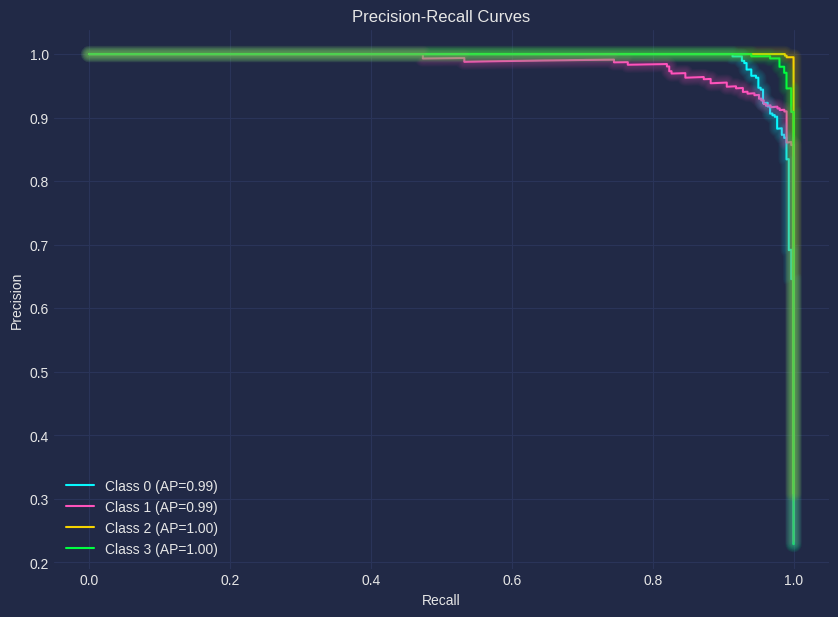

In [11]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Precision-Recall Curve per class
plt.figure(figsize=(10, 7))
for i in range(len(os.listdir(train_path))):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
    ap = average_precision_score(y_test_bin[:, i], y_prob[:, i])
    plt.plot(recall, precision, label=f"Class {i} (AP={ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.grid(True)
mplcyberpunk.make_lines_glow()
plt.show()


# Step 12: Upload & Detect Image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


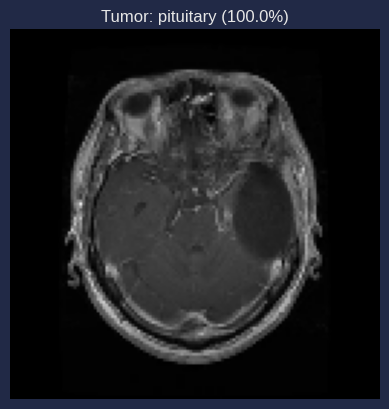

In [14]:
import tkinter as tk
from tkinter import filedialog

def upload_and_predict():
    root = tk.Tk()
    root.withdraw()  # Hide GUI
    img_path = filedialog.askopenfilename()
    if img_path:
        tumor_predictor(img_path, model)

# Call this function to test image upload and prediction
upload_and_predict()


# Step 13: Export to CSV (Predictions + Ground Truth)

In [15]:
import pandas as pd

# Export test results to CSV
pred_labels = [tumor_types[i] for i in y_pred]
true_labels = [tumor_types[i] for i in y_test]

df_results = pd.DataFrame({
    "Image": test_images,
    "True Label": true_labels,
    "Predicted Label": pred_labels
})
df_results.to_csv("prediction_results.csv", index=False)
print("✅ Results saved to prediction_results.csv")


✅ Results saved to prediction_results.csv


# Step 14: Top-K Accuracy Visualization

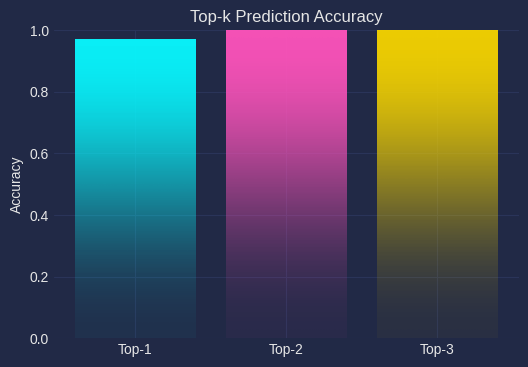

In [22]:
# Calculate top-k accuracy for top-1, top-2, top-3
def compute_top_k_accuracies(probs, true_labels, k_list=[1, 2, 3]):
    results = {}
    for k in k_list:
        top_k_preds = np.argsort(probs, axis=1)[:, -k:]
        correct = sum([true_labels[i] in top_k_preds[i] for i in range(len(true_labels))])
        results[k] = correct / len(true_labels)
    return results

topk_scores = compute_top_k_accuracies(y_prob, y_test)

colors = ["C0", "C1", "C2", "C3"]

# Plot top-k results
plt.figure(figsize=(6, 4))
bars=plt.bar([f"Top-{k}" for k in topk_scores], topk_scores.values(), color=colors)
mplcyberpunk.add_bar_gradient(bars=bars)
plt.ylim(0, 1)
plt.title("Top-k Prediction Accuracy")
plt.ylabel("Accuracy")
plt.grid(True, axis='y')
plt.show()


# Step 15: Confidence Plot Cell

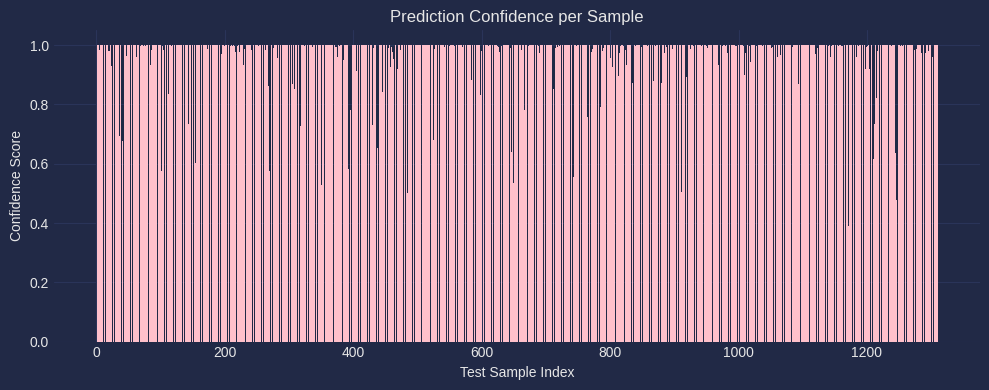

In [17]:
# Confidence for each test prediction
confidences = np.max(y_prob, axis=1)

plt.figure(figsize=(10, 4))
plt.bar(range(len(confidences)), confidences, color='pink')
plt.title("Prediction Confidence per Sample")
plt.xlabel("Test Sample Index")
plt.ylabel("Confidence Score")
plt.ylim(0, 1.05)
plt.grid(True, axis='y')
plt.tight_layout()
mplcyberpunk.make_lines_glow()
plt.show()


# Step 16: Misclassified Images Viewer

❌ Misclassified Samples: 40


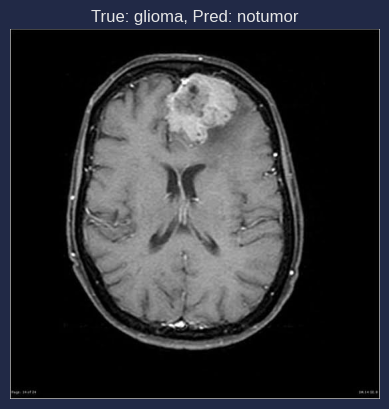

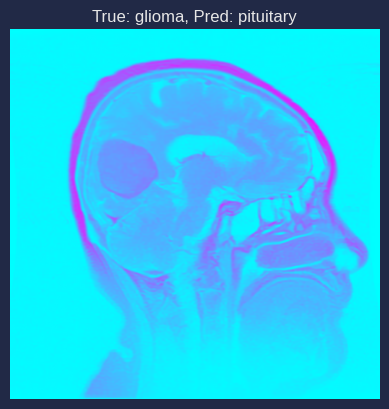

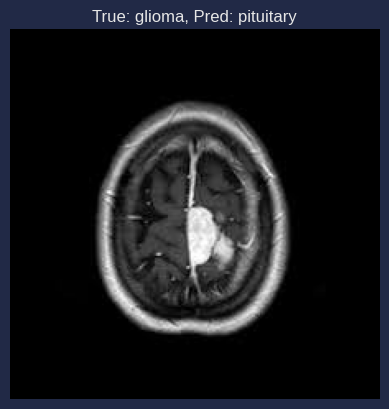

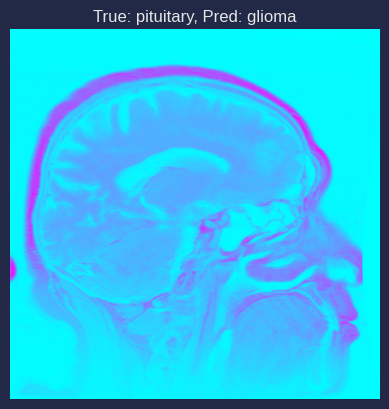

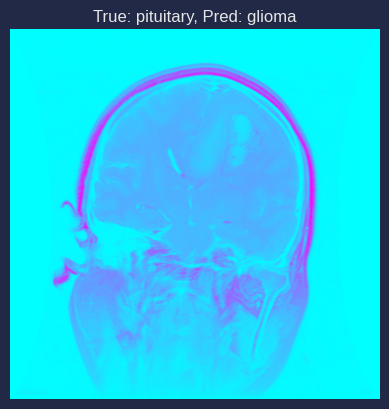

In [20]:
# Show incorrect predictions with actual and predicted labels
wrong_idxs = [i for i in range(len(y_test)) if y_test[i] != y_pred[i]]
print(f"❌ Misclassified Samples: {len(wrong_idxs)}")

for idx in wrong_idxs[:5]:  # show first 5 mistakes
    img = Image.open(test_images[idx])
    plt.imshow(img)
    plt.title(f"True: {tumor_types[y_test[idx]]}, Pred: {tumor_types[y_pred[idx]]}")
    plt.axis('off')
    plt.show()


# Step 17: Class-wise Accuracy Breakdown

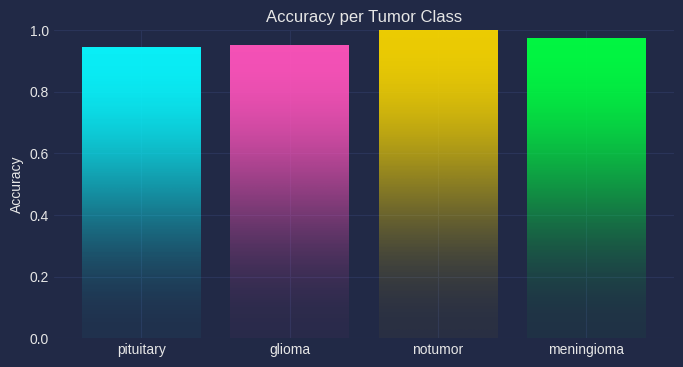

In [12]:
from sklearn.metrics import accuracy_score

# Compute accuracy per class
class_accuracy = {}
for i, label in enumerate(tumor_types):
    indices = [j for j in range(len(y_test)) if y_test[j] == i]
    true_subset = [y_test[j] for j in indices]
    pred_subset = [y_pred[j] for j in indices]
    class_accuracy[label] = accuracy_score(true_subset, pred_subset)

colors = ["C0", "C1", "C2", "C3"]

# Plot per-class accuracy
plt.figure(figsize=(8, 4))
bars = plt.bar(class_accuracy.keys(), class_accuracy.values(), color=colors)
mplcyberpunk.add_bar_gradient(bars=bars)
plt.title("Accuracy per Tumor Class")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.show()


# Step 18: Interactive Prediction Slider

In [16]:
from ipywidgets import interact, IntSlider

def show_prediction_by_index(i):
    img = Image.open(test_images[i]).resize((128, 128))
    plt.imshow(img)
    plt.axis("off")
    pred_class = tumor_types[y_pred[i]]
    true_class = tumor_types[y_test[i]]
    plt.title(f"True: {true_class} | Predicted: {pred_class}")
    plt.show()

interact(show_prediction_by_index, i=IntSlider(min=0, max=len(test_images)-1, step=1, value=0))


interactive(children=(IntSlider(value=0, description='i', max=1310), Output()), _dom_classes=('widget-interact…

<function __main__.show_prediction_by_index(i)>

# Step 19: t-SNE Visualization of Feature Embeddings


* Visualize how the model internally separates classes based on the penultimate layer.




In [20]:
from sklearn.manifold import TSNE

# Get penultimate layer outputs
feature_extractor = tf.keras.Model(inputs=model.input, outputs=model.layers[-3].output)
features = feature_extractor.predict(x_test)

# t-SNE reduction to 2D
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(features)

# Plot
plt.figure(figsize=(8, 6))
for i, label in enumerate(np.unique(y_test)):
    indices = np.where(np.array(y_test) == label)
    plt.scatter(tsne_result[indices, 0], tsne_result[indices, 1], label=tumor_types[label], alpha=0.6)

plt.legend()
plt.title("t-SNE Projection of Learned Features")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.tight_layout()
mplcyberpunk.make_lines_glow()
plt.show()


KeyError: 'Exception encountered when calling Functional.call().\n\n\x1b[1m126501489782992\x1b[0m\n\nArguments received by Functional.call():\n  • inputs=tf.Tensor(shape=(32, 128, 128, 3), dtype=float32)\n  • training=False\n  • mask=None'

# Step 20: Training Time and Inference Speed Benchmark


*   Show how fast the model trains and predicts — useful for real-world performance reporting.



In [13]:
import time

# Training time per epoch (estimate)
start_time = time.time()
_ = model.fit(image_batch_gen(train_images, train_classes, size=BATCH, reps=1), steps_per_epoch=STEPS, epochs=1)
train_duration = time.time() - start_time
print(f"🕒 Approximate training time for 1 epoch: {train_duration:.2f} seconds")

# Inference time
start = time.time()
_ = model.predict(x_test)
print(f"🕒 Inference time on test set: {time.time() - start:.2f} seconds")


178/178 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0253 - sparse_categorical_accuracy: 0.9902
🕒 Approximate training time for 1 epoch: 6.01 seconds
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
🕒 Inference time on test set: 1.17 seconds


# Step 21: Class Imbalance Detection


*   Automatically warn if classes are imbalanced in the training set.



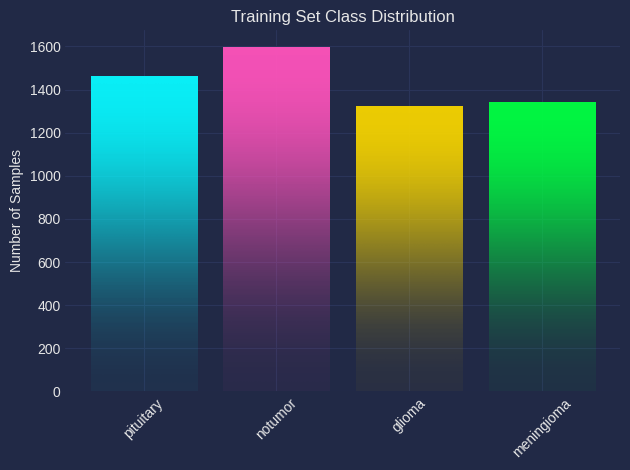

In [14]:
from collections import Counter

colors = ["C0", "C1", "C2", "C3"]

class_counts = Counter(train_classes)
bars = plt.bar(class_counts.keys(), class_counts.values(), color=colors)
mplcyberpunk.add_bar_gradient(bars=bars)
plt.xticks(rotation=45)
plt.title("Training Set Class Distribution")
plt.ylabel("Number of Samples")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

if max(class_counts.values()) / min(class_counts.values()) > 1.5:
    print("⚠️ Class imbalance detected. Consider augmentation or weighted loss.")


# Step 22: False Positive and False Negative Viewer


*   Inspect which types of mistakes the model is making.



🔍 False Positives:


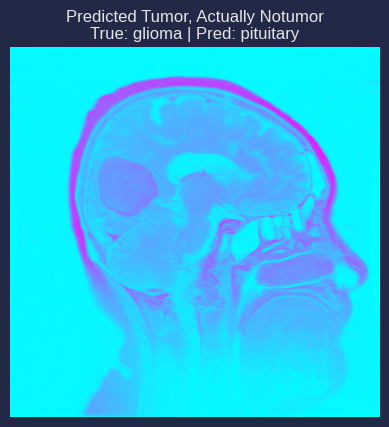

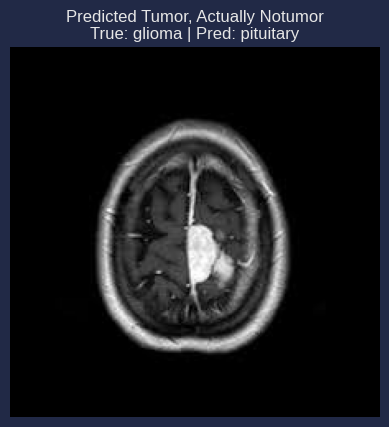

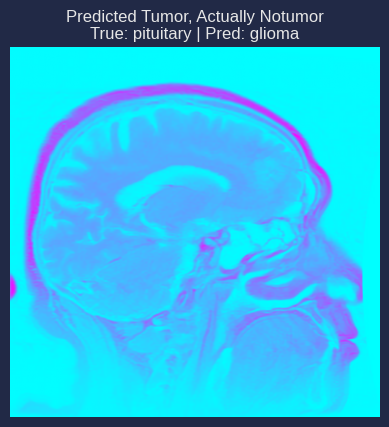

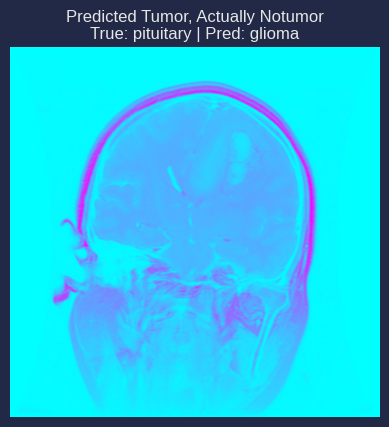

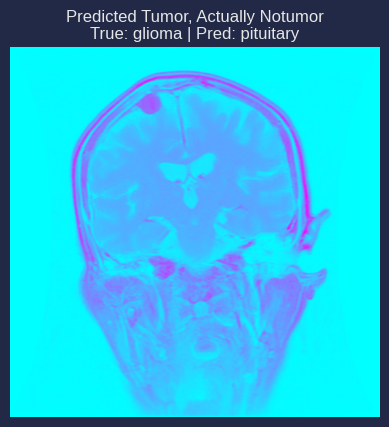

🔍 False Negatives:


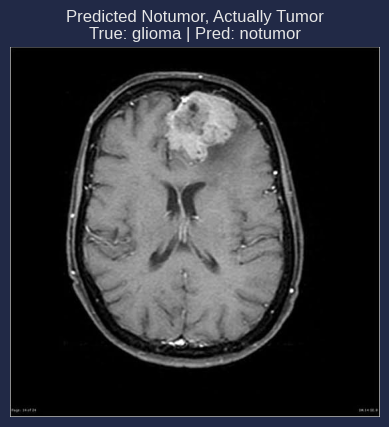

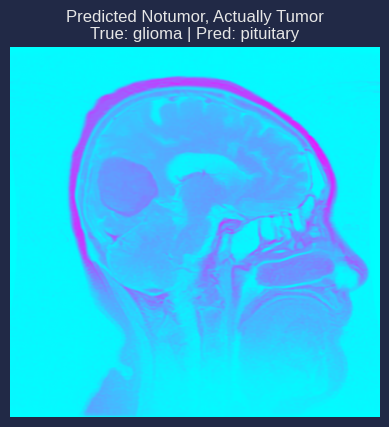

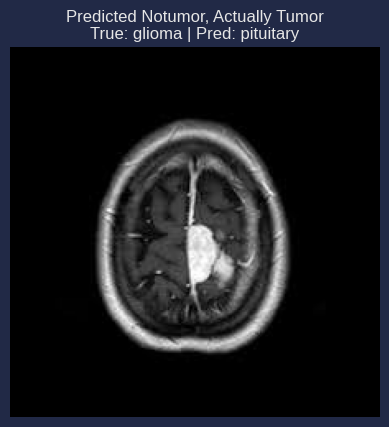

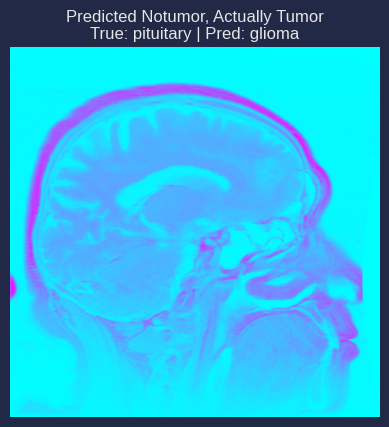

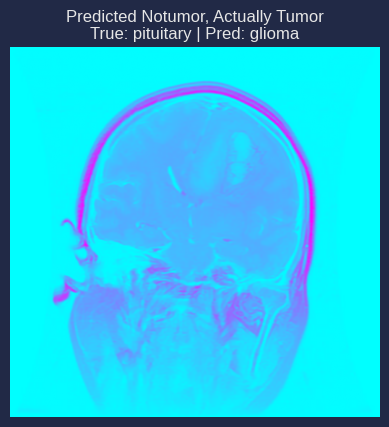

In [15]:
# Show a few false positives and false negatives
false_positives = [i for i in range(len(y_test)) if y_pred[i] != y_test[i] and tumor_types[y_pred[i]] != 'notumor']
false_negatives = [i for i in range(len(y_test)) if y_pred[i] != y_test[i] and tumor_types[y_test[i]] != 'notumor']

def show_samples(indices, title):
    for idx in indices[:5]:
        img = Image.open(test_images[idx])
        plt.imshow(img)
        plt.title(f"{title}\nTrue: {tumor_types[y_test[idx]]} | Pred: {tumor_types[y_pred[idx]]}")
        plt.axis('off')
        plt.show()

print("🔍 False Positives:")
show_samples(false_positives, "Predicted Tumor, Actually Notumor")

print("🔍 False Negatives:")
show_samples(false_negatives, "Predicted Notumor, Actually Tumor")


# Step 23: Prediction Distribution Histogram


*   Show how confident the model is across all samples (to spot overconfidence or underconfidence).



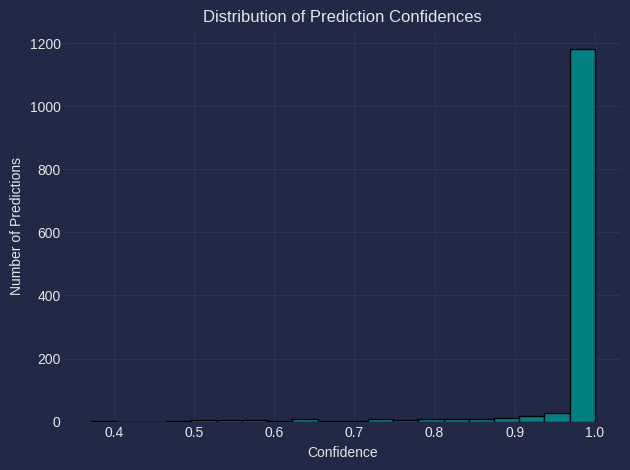

In [18]:
plt.hist(confidences, bins=20, color='teal', edgecolor='black')

plt.title("Distribution of Prediction Confidences")
plt.xlabel("Confidence")
plt.ylabel("Number of Predictions")
plt.grid(True)
plt.tight_layout()

plt.show()


# Step 24: Report-Ready Summary


In [23]:
print("📊 Model Summary:")
print(f"Total Samples: {len(train_images) + len(test_images)}")
print(f"Training Classes: {sorted(list(set(train_classes)))}")
print(f"Test Accuracy: {np.mean(y_test == y_pred):.2f}")
print(f"Misclassified Samples: {len(wrong_idxs)}")
print(f"Top-1 Accuracy: {topk_scores[1]*100:.2f}% | Top-3 Accuracy: {topk_scores[3]*100:.2f}%")


📊 Model Summary:
Total Samples: 7023
Training Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Test Accuracy: 0.97
Misclassified Samples: 40
Top-1 Accuracy: 96.95% | Top-3 Accuracy: 100.00%
